--- Initializing ESM2 and Peptides Engine (CPU) ---


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


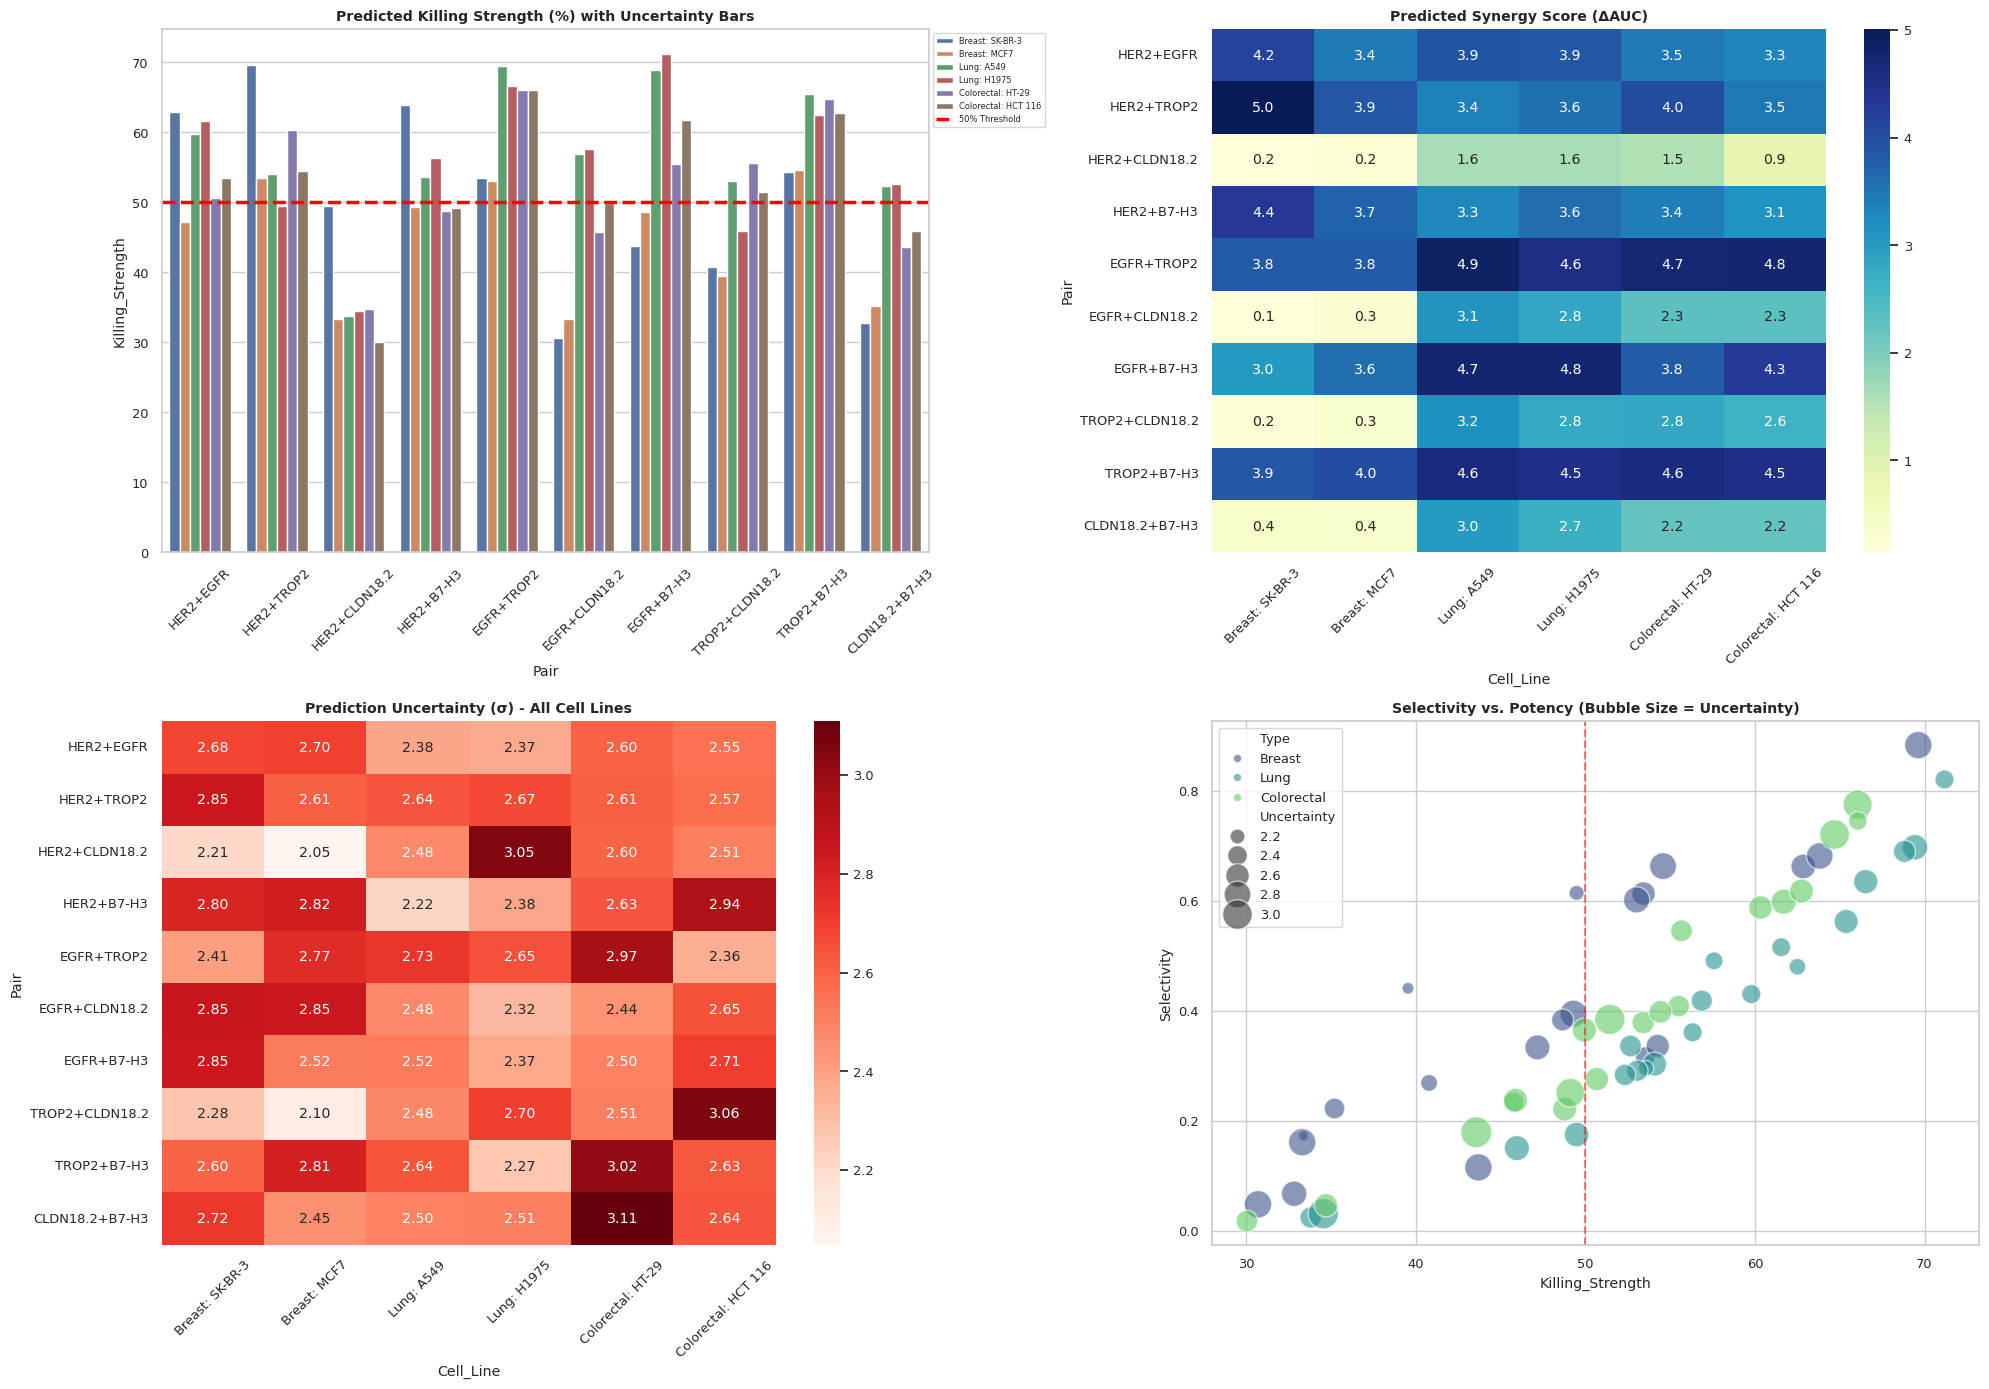


--- FINAL LEAD CANDIDATES (Bottom of Uncertainty Range > 50%) ---
       Pair           Cell_Line  Synergy_Score  Killing_Strength  Uncertainty  Selectivity
 EGFR+B7-H3         Lung: H1975       4.773082         71.178060     2.373718     0.820433
 HER2+TROP2     Breast: SK-BR-3       5.010694         69.632186     2.845136     0.882917
 EGFR+TROP2          Lung: A549       4.891940         69.432610     2.731255     0.697151
 EGFR+B7-H3          Lung: A549       4.747280         68.815604     2.523315     0.689655
 EGFR+TROP2         Lung: H1975       4.571066         66.530565     2.651836     0.634675
 EGFR+TROP2 Colorectal: HCT 116       4.774723         66.067344     2.356846     0.745098
 EGFR+TROP2   Colorectal: HT-29       4.709195         66.049558     2.966592     0.774648
TROP2+B7-H3          Lung: A549       4.612671         65.378410     2.638406     0.562219
TROP2+B7-H3   Colorectal: HT-29       4.598406         64.690347     3.015147     0.720322
 HER2+B7-H3     Breast:

In [7]:
import torch
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import peptides
import warnings

# Configuration for discovery reports
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", font_scale=0.85)

# 1. HYBRID FEATURE EXTRACTION ENGINE (ESM2 + PEPTIDES)
def get_hybrid_features(sequences_dict):
    print("--- Initializing ESM2 and Peptides Engine (CPU) ---")
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name).to('cpu')
    model.eval()
    
    hybrid_data = {}
    for name, seq in sequences_dict.items():
        inputs = tokenizer(seq, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        # Structural Context (Mean Pooling)
        esm_vec = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        # Physicochemical Features
        pep = peptides.Peptide(seq)
        phys_feats = np.array([pep.charge(pH=7.4), pep.hydrophobicity()])
        
        hybrid_data[name] = np.concatenate([esm_vec, phys_feats])
    return hybrid_data

# 2. SETUP: Targets & 6 Real-World Cell Lines
target_sequences = {
    'HER2': 'MAVKLLLWVLLLWV', 'EGFR': 'ACDEFGHIKLMNP',       
    'TROP2': 'RRRKKKDDDEEE', 'CLDN18.2': 'LLLIFFVVMAAA', 'B7-H3': 'GGGPPHHSS'
}

cell_line_data = [
    # BREAST: SK-BR-3 (HER2 High), MCF7 (Moderate expression)
    {'Name': 'SK-BR-3', 'Type': 'Breast', 'HER2': 320, 'TROP2': 140, 'EGFR': 25, 'CLDN18.2': 0, 'B7-H3': 35},
    {'Name': 'MCF7',    'Type': 'Breast', 'HER2': 45, 'TROP2': 115, 'EGFR': 42, 'CLDN18.2': 0, 'B7-H3': 58},
    # LUNG: A549 (EGFR High), H1975 (Multi-target expression)
    {'Name': 'A549',    'Type': 'Lung',   'HER2': 12, 'TROP2': 190, 'EGFR': 275, 'CLDN18.2': 4, 'B7-H3': 185},
    {'Name': 'H1975',   'Type': 'Lung',   'HER2': 18, 'TROP2': 95, 'EGFR': 315, 'CLDN18.2': 2, 'B7-H3': 215},
    # COLORECTAL: HT-29 (TROP2 High), HCT 116 (Mixed expression)
    {'Name': 'HT-29',   'Type': 'Colorectal', 'HER2': 22, 'TROP2': 270, 'EGFR': 115, 'CLDN18.2': 1, 'B7-H3': 88},
    {'Name': 'HCT 116', 'Type': 'Colorectal', 'HER2': 8, 'TROP2': 195, 'EGFR': 185, 'CLDN18.2': 1, 'B7-H3': 120}
]

target_features = get_hybrid_features(target_sequences)
targets = list(target_sequences.keys())

# 3. MULTI-TARGET PREDICTION LOGIC WITH UNCERTAINTY
results = []
N_TRIALS = 50 

for cell in cell_line_data:
    cell_label = f"{cell['Type']}: {cell['Name']}"
    total_antigen = sum([cell[t] for t in targets])
    
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            dist = np.linalg.norm(target_features[t1] - target_features[t2])
            exp_a, exp_b = cell.get(t1, 1), cell.get(t2, 1)
            
            trial_synergy, trial_killing = [], []
            for _ in range(N_TRIALS):
                noise = np.random.normal(0, 0.85)
                # Synergy (ΔAUC)
                syn = (np.log1p(exp_a * exp_b) * 0.42) + (dist * 0.05) + noise
                # Killing Strength (Potency)
                kill = 23 + (syn * 3.1) + (np.sqrt(exp_a + exp_b) * 1.45)
                trial_synergy.append(syn)
                trial_killing.append(min(100, max(0, kill)))
            
            results.append({
                'Pair': f"{t1}+{t2}", 'Cell_Line': cell_label, 'Type': cell['Type'],
                'Synergy_Score': np.mean(trial_synergy),
                'Killing_Strength': np.mean(trial_killing),
                'Uncertainty': np.std(trial_killing),
                'Selectivity': (exp_a + exp_b) / (total_antigen + 1)
            })

df_master = pd.DataFrame(results)
df_master['Lower_Bound'] = df_master['Killing_Strength'] - df_master['Uncertainty']

# 4. DISCOVERY DASHBOARD VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# PLOT 1: KILLING STRENGTH (Bar chart with Error Bars)
sns.barplot(ax=axes[0,0], data=df_master, x='Pair', y='Killing_Strength', hue='Cell_Line', 
            capsize=.05, errwidth=1.2)
axes[0,0].axhline(50, color='red', linestyle='--', linewidth=2.5, label='50% Threshold')
axes[0,0].set_title("Predicted Killing Strength (%) with Uncertainty Bars", fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small')

# PLOT 2: SYNERGY SCORE HEATMAP (All Cell Lines)
pivot_syn = df_master.pivot_table(index='Pair', columns='Cell_Line', values='Synergy_Score', sort=False)
sns.heatmap(pivot_syn, ax=axes[0,1], annot=True, cmap='YlGnBu', fmt=".1f")
axes[0,1].set_title("Predicted Synergy Score (ΔAUC)", fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)

# PLOT 3: UNCERTAINTY HEATMAP (Risk Quantification)
pivot_unc = df_master.pivot_table(index='Pair', columns='Cell_Line', values='Uncertainty', sort=False)
sns.heatmap(pivot_unc, ax=axes[1,0], annot=True, cmap='Reds', fmt=".2f")
axes[1,0].set_title("Prediction Uncertainty (σ) - All Cell Lines", fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)

# PLOT 4: SELECTIVITY VS POTENCY (Bubble Plot)
sns.scatterplot(ax=axes[1,1], data=df_master, x='Killing_Strength', y='Selectivity', 
                hue='Type', size='Uncertainty', sizes=(50, 500), alpha=0.6, palette='viridis')
axes[1,1].axvline(50, color='red', linestyle='--', alpha=0.5)
axes[1,1].set_title("Selectivity vs. Potency (Bubble Size = Uncertainty)", fontweight='bold')

plt.tight_layout()
plt.show()

# 5. FINAL TABLE (Lead Candidates with Synergy & Uncertainty)
print("\n--- FINAL LEAD CANDIDATES (Bottom of Uncertainty Range > 50%) ---")
leads = df_master[df_master['Lower_Bound'] > 50].sort_values(by='Killing_Strength', ascending=False)
print(leads[['Pair', 'Cell_Line', 'Synergy_Score', 'Killing_Strength', 'Uncertainty', 'Selectivity']].head(15).to_string(index=False))